## Churn Prediction 

In [42]:
# import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import pickle
import json
import warnings

# Configurations:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 1500)
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1500)


#### Import the dataset

In [43]:
df = pd.read_csv('.\data\BankChurners.csv')

#### Understanding the data

In [44]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.000000,777,11914.000000,1.335000,1144,42,1.625000,0.061000,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000000,864,7392.000000,1.541000,1291,33,3.714000,0.105000,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000000,0,3418.000000,2.594000,1887,20,2.333000,0.000000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.000000,2517,796.000000,1.405000,1171,20,2.333000,0.760000,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.000000,0,4716.000000,2.175000,816,28,2.500000,0.000000,0.000022,0.999980


In [45]:
df.shape

(10127, 23)

In [46]:
df.isnull().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

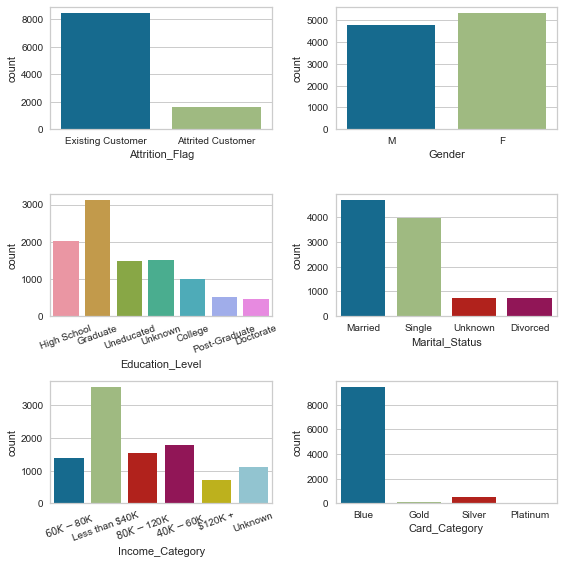

In [48]:
# Visualizing the categotical features in one plot
fig, ax = plt.subplots(3, 2, figsize = (8, 8))
sns.countplot(df['Attrition_Flag'], ax = ax[0, 0])
sns.countplot(df['Gender'], ax = ax[0, 1])
f1 = sns.countplot(df['Education_Level'], ax = ax[1, 0])
f1.set_xticklabels(f1.get_xticklabels(), rotation = 20)
sns.countplot(df['Marital_Status'], ax = ax[1, 1])
f2 = sns.countplot(df['Income_Category'], ax = ax[2, 0])
f2.set_xticklabels(f2.get_xticklabels(), rotation = 20)
sns.countplot(df['Card_Category'], ax = ax[2, 1])
fig.tight_layout()

### Data Preprocessing

In [8]:
# select except the last two (unnecessary) columns
df = df.iloc[:, :-2]
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.000000,777,11914.000000,1.335000,1144,42,1.625000,0.061000
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000000,864,7392.000000,1.541000,1291,33,3.714000,0.105000
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000000,0,3418.000000,2.594000,1887,20,2.333000,0.000000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.000000,2517,796.000000,1.405000,1171,20,2.333000,0.760000
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.000000,0,4716.000000,2.175000,816,28,2.500000,0.000000


In [9]:
# Statictical information and Variables relationships
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,739177606.333663,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,36903783.450231,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,708082083.000000,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,713036770.500000,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,717926358.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,773143533.000000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,828343083.000000,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [10]:
# convert Attrited Customer to 1, Existing Customer to 0
df['Attrition_Flag'] = df['Attrition_Flag'].replace({'Attrited Customer':1,'Existing Customer':0})

<AxesSubplot:>

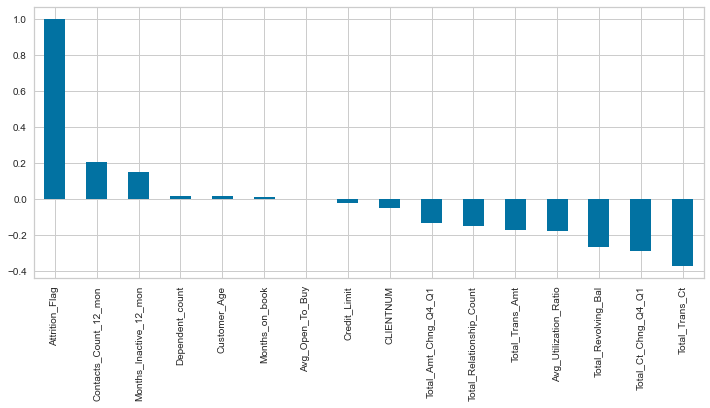

In [11]:
# correlation in glimps:
df_corr= df.iloc[:,0:]

plt.figure(figsize=(12,5))
df_corr.corr()['Attrition_Flag'].sort_values(ascending = False).plot(kind='bar')

#### Observations:

- Correlation of gender, marital status, education level and customer age with Attrition flag are low.
- contacts_count_12_mon, Months-Inactive_12_mon seem to be positively correlated with churn. While, credit_limit,Total_Amt_Chng_A4_Q1, Total_Relationship_count, Total_Revolving_Bal, Total_Trans_Ct seem to be negatively correlated with churn.
- It seems that Card_Category and Avg_Open_To_Buy has lower correlation whith churn.

#### Feature Selection

According to the observation made, three features namely:Total_Revolving_Bal, Total_Ct_Chng_Q4_Q1 
and Months_Inactive_12_mon has been selected to build the model.

In [12]:
df_train = df[['Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1','Months_Inactive_12_mon']]

#### Find the optimal value for k for k-means algorithm

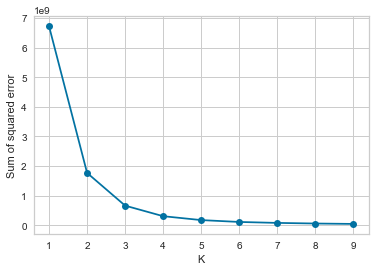

In [13]:
# Elbow plot

sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df_train)
    sse.append(km.inertia_)
    
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse,  marker='o')    

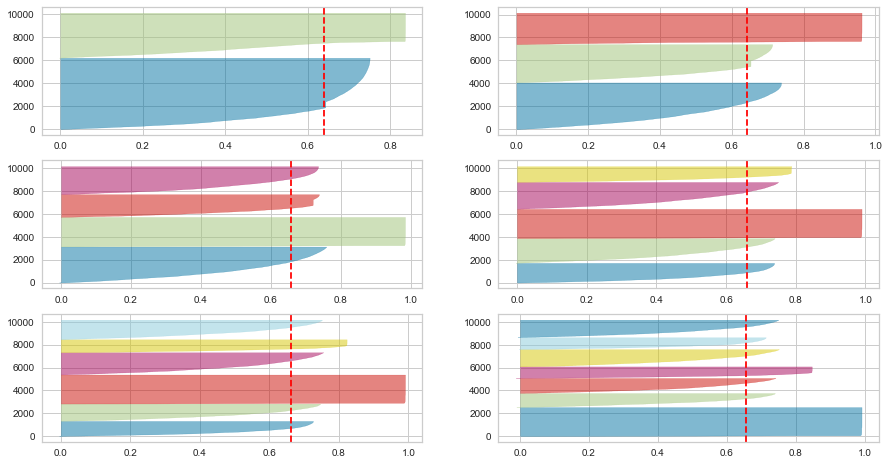

In [14]:
# Using Silhoutte score for identifying the optimum value of k
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_train) 

#### Training the model using K-means clustering algorithm

In [15]:
km = KMeans(n_clusters=3)
km.fit_transform(df_train)
y_pred = km.predict(df_train)
centroids = km.cluster_centers_

# Calculate Silhoutte Score
score = silhouette_score(df_train, km.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.643


In [16]:
# add the predicted value to the main and training dataset
df_train['cluster'] = y_pred
df['cluster'] = y_pred

In [17]:
# function to calculate the churn rate

def churn_rate(df, cluster_id):
    cluster = df[df['cluster']== cluster_id]
    df_count = cluster["Attrition_Flag"].value_counts()
    churn_rate = (df_count[1] / (df_count[0] + df_count[1]) * 100)
    churn_rate = churn_rate.round(decimals = 2)
    
    return churn_rate

In [18]:
# function to calculate the female %

def gender(df, cluster_id):
    cluster = df[df['cluster']== cluster_id]
    df_count = cluster["Gender"].value_counts()
    f_count = (df_count['F'] / (df_count['F'] + df_count['M']) * 100)
    f_count = f_count.round(decimals = 2)
    
    return f_count

In [19]:
# call the function to calculate the churn rate and female % for each cluster
churn_rate_info = {}
gender_info = {}
for i in range(0,3): 
    churn_rate_info[i] = churn_rate(df, i)
    gender_info[i] = gender(df, i)
    

#### Save the model and calculations locally

In [20]:
# save the model to disk
filename = '.\model\clustering_model.sav'
pickle.dump(km, open(filename, 'wb'))

# save the dictionary into a json file
# Serializing json
json_object = json.dumps(churn_rate_info, indent=4)
 
# Writing to churn_rate_info.json
with open(".\data\churn_rate_info.json", "w") as outfile:
    outfile.write(json_object)
     
# Writing to churn_rate_info.json
json_object = json.dumps(gender_info, indent=4)
with open(".\data\gender_info.json", "w") as outfile:
    outfile.write(json_object)    

#### Visualize the cluster

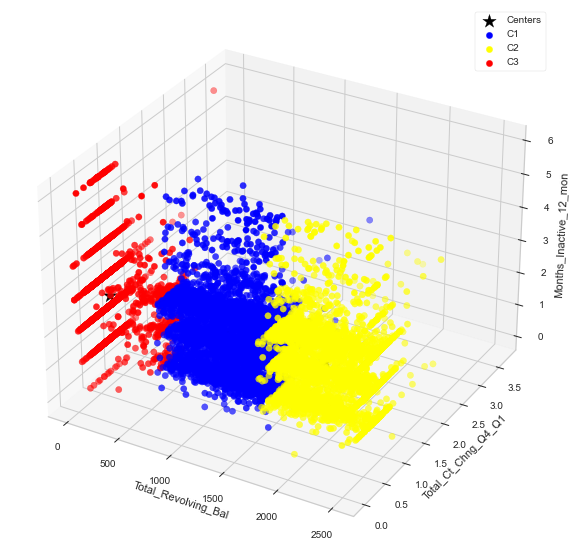

In [45]:
df1 = df_train[df_train.cluster==0]
df2 = df_train[df_train.cluster==1]
df3 = df_train[df_train.cluster==2]

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],c="black",s=200,label="Centers",alpha=1, marker='*')
ax.scatter(df1['Total_Revolving_Bal'],df1['Total_Ct_Chng_Q4_Q1'],df1['Months_Inactive_12_mon'],c="blue",s=40,label="C1")
ax.scatter(df2['Total_Revolving_Bal'],df2['Total_Ct_Chng_Q4_Q1'],df2['Months_Inactive_12_mon'],c="yellow",s=40,label="C2")
ax.scatter(df3['Total_Revolving_Bal'],df3['Total_Ct_Chng_Q4_Q1'],df3['Months_Inactive_12_mon'],c="red",s=40,label="C3")
plt.legend(loc="upper right",framealpha=1, frameon=True)
ax.set_xlabel("Total_Revolving_Bal")
ax.set_ylabel("Total_Ct_Chng_Q4_Q1")
ax.set_zlabel("Months_Inactive_12_mon")

plt.show()

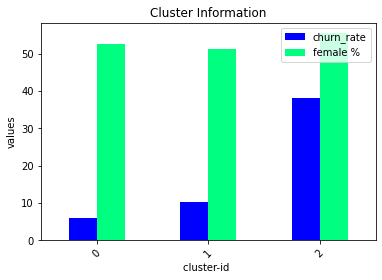

In [41]:
# Comparison of the clusters

df_churn = pd.read_json(".\data\churn_rate_info.json", orient="index")
df_churn.columns = ['churn_rate']
df_gender = pd.read_json(".\data\gender_info.json", orient="index")
df_gender.columns = ['female %']
df = pd.concat([df_churn, df_gender], axis=1)

# plot the results
ax = df.plot(kind='bar',stacked = False, colormap = 'winter')
plt.xticks(rotation = 45)
plt.xlabel('cluster-id ')
plt.ylabel('values')
plt.title('Cluster Information')
# df.plot.bar() 
plt.show()
